# Market Basket Analysis with RFM analysis

Market Basket Analysis decodes customer purchasing patterns through transactional data, revealing item associations.
When integrated with RFM analysis, businesses gain a holistic understanding to alter strategies and enhance customer
satisfaction. Our project merges Market Basket Analysis and RFM (Recency, Frequency, Monetary Value)
Analysis to decode customer purchasing patterns. This combined approach uncovers correlations
in product purchases and customer behavior, empowering us to tailor strategies for enhanced
customer satisfaction. By leveraging these insights, we aim to optimize product placement,
marketing strategies, and promotions to meet diverse customer preferences, fostering stronger
relationships and loyalty

Importing the Libraries

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.cluster import KMeans #For customer segmentation
from sklearn.preprocessing import StandardScaler
import warnings
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
warnings.filterwarnings("ignore")

In [5]:
#Proprocessing the dataset
df1 = pd.read_excel('/content/online_retail_09_10.xlsx')
df2 = pd.read_excel('/content/online_retail_10_11.xlsx')
df = pd.concat([df1, df2])
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


##### Understanding the dataset

In this dataset we have the following rows

1. InvoiceNo: Invoice number. <br>
2. StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. <br>
3. Description: Product (item) name. Nominal. <br>
4. Quantity: The quantities of each product (item) per transaction. Numeric.	<br>
5. InvoiceDate: Invoice date and time. Numeric. The day and time when a transaction was generated. <br>
6. UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). <br>
7. CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. <br>
8. Country: Country name. Nominal. The name of the country where a customer resides. <br>

In [6]:
print(f"Shape of the dataframe : {df.shape}")
print(f"Number of transactions : {df.shape[0]}")
print(f"Number of features used : {df.shape[1]}")

Shape of the dataframe : (1067371, 8)
Number of transactions : 1067371
Number of features used : 8


### Datatype of each column

In [7]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

* The invoice date is in the correct datetime format
* Customer ID can be converted to int/str instead of float as it constitutes of only numbers - for that we'll have to check if it contains NULL values



In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


### Check for NULL values

Here we can see that the 'Description' and 'Customer ID' columns have null values.

In [9]:
# Check how many columns have null values in Description and Customer ID
df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [10]:
# Display the columns where Customer ID is Null
df[df['Customer ID'].isna()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [11]:
df.dropna(subset = 'Customer ID', axis=0, inplace = True)
print(f'Shape after removing null values from the dataset : {df.shape}')

Shape after removing null values from the dataset : (824364, 8)


In [12]:
df.isna().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

There are no missing values now

### Check for negative values

In [13]:
df.describe()

,Quantity,Price,Customer ID
count,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,15324.638504
std,188.976099,70.241388,1697.464450
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,5.000000,1.950000,15255.000000
75%,12.000000,3.750000,16797.000000
max,80995.000000,38970.000000,18287.000000


The above table indicated there are negative values in the 'Quantity' and 'Price' column. We'll have to remove those as these indicate cancelled or returned products

In [14]:
# These many columns contain negative values
df[(df['Quantity'] <= 0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [15]:
df['Invoice'].str.contains('C').sum()

18744

In [16]:
df = df[~df['Invoice'].str.contains('C', na=False)]
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


We have taken care of all the negative values in the dataframe

### Remove duplicate values

In [17]:
df.duplicated().sum()

26125

In [18]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [19]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


Now, our data is free of all missing values, duplicate values, and negative values

### Check for Outliers

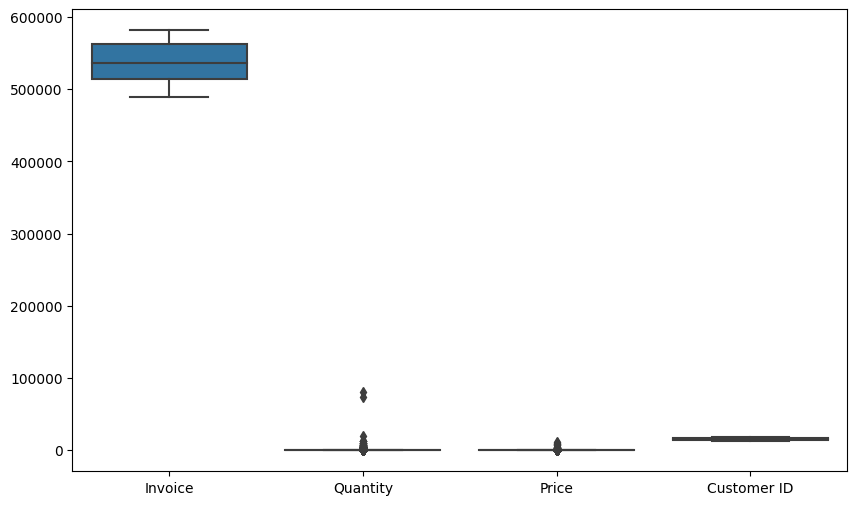

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = df)
plt.show()

From the above boxplot and based on df.describe, there exists outliers in the Quantity and Price column

In [21]:
# We'll remove only the extreme outliers as we have lost enough data already
Q1 = df[['Quantity', 'Price']].quantile(0.01)
Q3 = df[['Quantity', 'Price']].quantile(0.99)
IQR = Q3 - Q1

df_outliers = df[((df[['Quantity', 'Price']] < (Q1 - 1.5 * IQR)) | (df[['Quantity', 'Price']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [22]:
df_outliers

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,12636.0,USA
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,130.00,12362.0,Belgium
217,489460,84598,BOYS ALPHABET IRON ON PATCHES,576,2009-12-01 10:46:00,0.21,16167.0,United Kingdom
575,489523,84879,ASSORTED COLOUR BIRD ORNAMENT,800,2009-12-01 11:46:00,1.45,12931.0,United Kingdom
1344,489562,84472,PINK AND LILAC QUILTED THROW,1,2009-12-01 13:07:00,45.95,17998.0,United Kingdom
...,...,...,...,...,...,...,...,...
537883,581375,21137,BLACK RECORD COVER FRAME,960,2011-12-08 12:36:00,3.39,16210.0,United Kingdom
540061,581457,23543,WALL ART KEEP CALM,698,2011-12-08 18:43:00,4.15,18102.0,United Kingdom
540070,581458,22197,POPCORN HOLDER,1500,2011-12-08 18:45:00,0.72,17949.0,United Kingdom
540071,581459,22197,POPCORN HOLDER,1200,2011-12-08 18:46:00,0.72,17949.0,United Kingdom


In [23]:
df = df.drop(df_outliers.index)
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [24]:
df.describe()

,Quantity,Price,Customer ID
count,774156.000000,774156.000000,774156.000000
mean,11.343552,2.899091,15320.665366
std,22.896442,2.926629,1694.962047
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,6.000000,1.950000,15249.000000
75%,12.000000,3.750000,16794.000000
max,352.000000,36.800000,18287.000000


In [25]:
#Final shape of the dataset
print(f' Final shape of the dataset : {df.shape}')

 Final shape of the dataset : (774156, 8)


### EDA to answer some Key questions

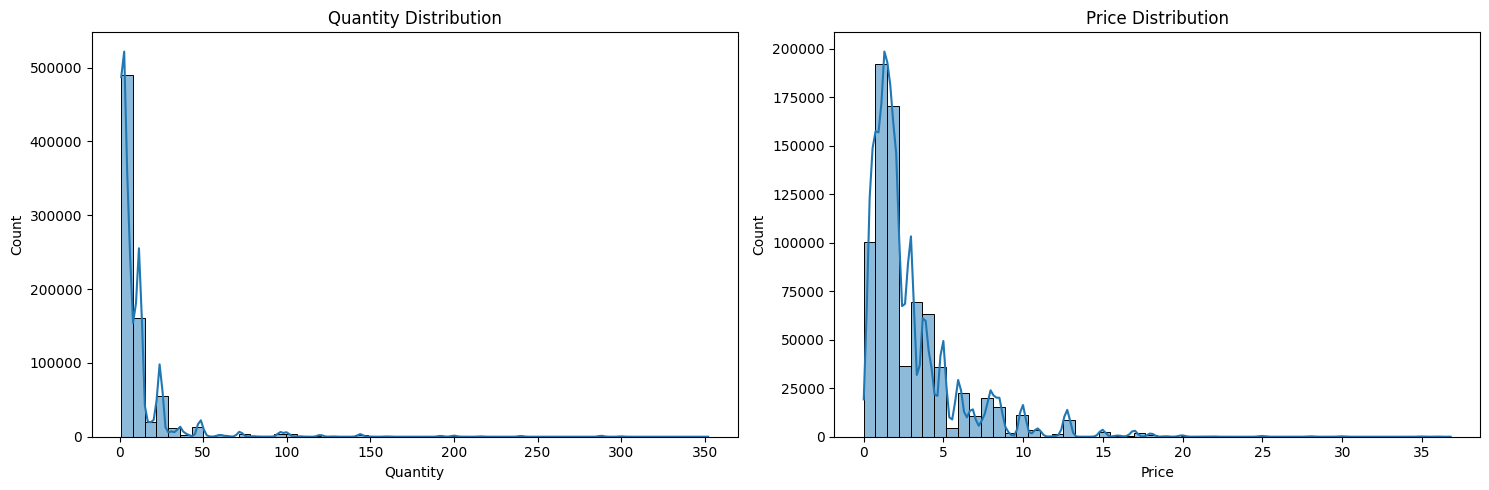

In [26]:
figs, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['Quantity'], bins = 50, kde = True, ax = axes[0])
axes[0].set_title('Quantity Distribution')

sns.histplot(df['Price'], bins = 50, kde = True, ax = axes[1])
axes[1].set_title('Price Distribution')

plt.tight_layout()
plt.show()

* We can see that the consumers buy things in lower quantity more (especially in the range of 1 - 10) <br>
* Also the consumers tend to buy more things in the lower price range

#### 1. Top 20 products based on Quantity sold

In [27]:
product_quantity = df.groupby(df['Description'])['Quantity'].sum().reset_index()
sorted_product_quantity = product_quantity.sort_values(by = 'Quantity', ascending = False)
# Let's get the top 20 products that are brought by consumers
top_20_products = sorted_product_quantity.head(20)

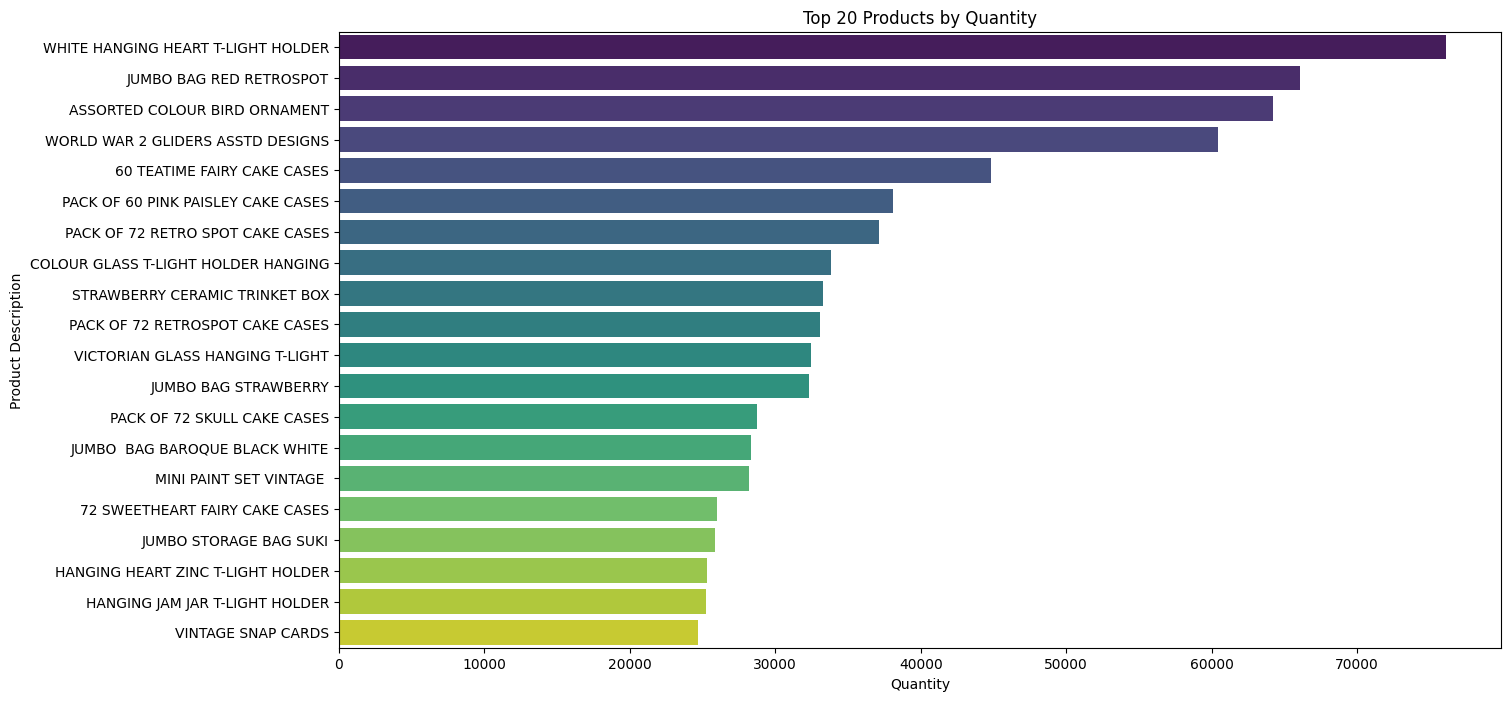

In [28]:
# Plot the bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x='Quantity', y='Description', data=top_20_products, palette='viridis')
plt.title(f'Top 20 Products by Quantity')
plt.xlabel('Quantity')
plt.ylabel('Product Description')
plt.show()

#### 2. Least sold products

In [29]:
product_quantity = df.groupby(df['Description'])['Quantity'].sum().reset_index()
sorted_product_quantity = product_quantity.sort_values(by = 'Quantity', ascending = True)
# Let's get the top 20 products that are brought by consumers
low_20_products = sorted_product_quantity.head(20)

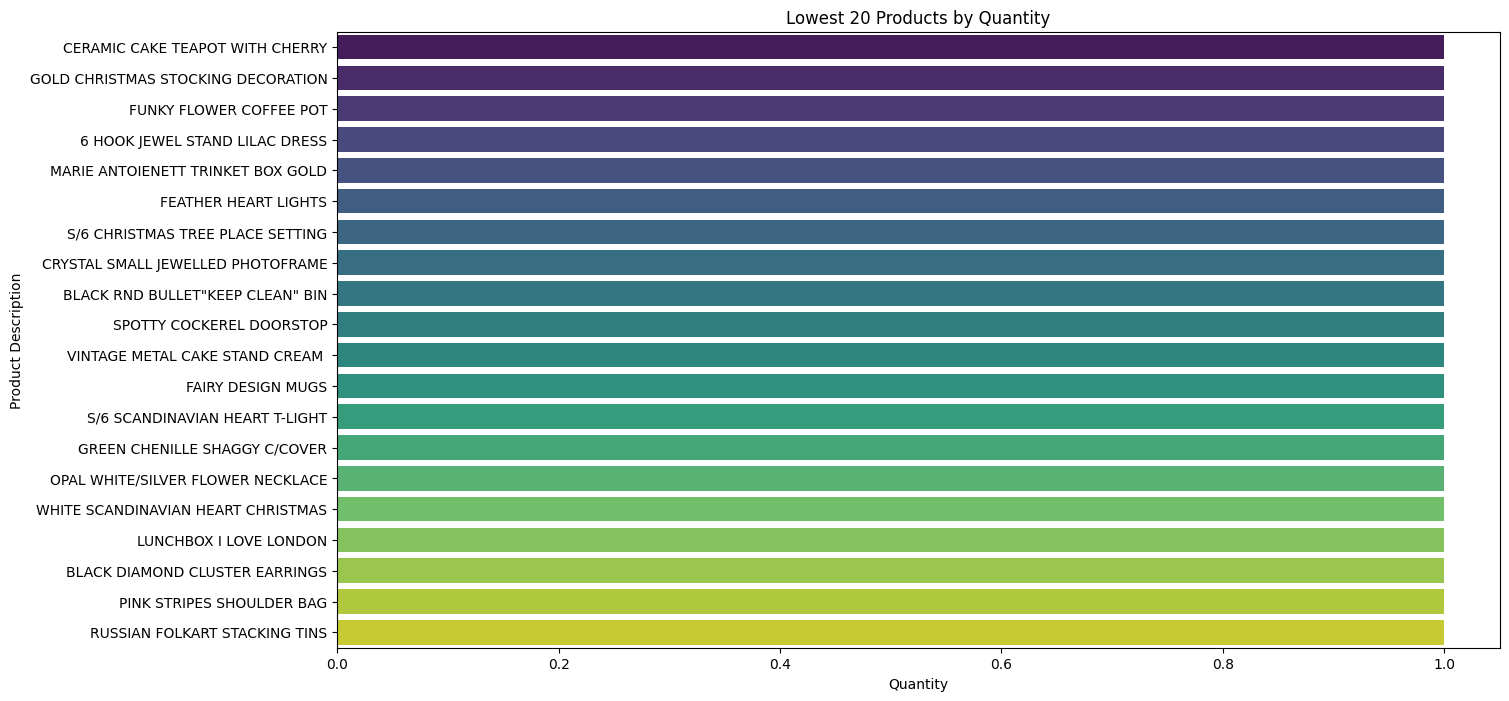

In [30]:
# Plot the bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x='Quantity', y='Description', data=low_20_products, palette='viridis')
plt.title(f'Lowest 20 Products by Quantity')
plt.xlabel('Quantity')
plt.ylabel('Product Description')
plt.show()

In [31]:
low_20_products.Description

910        CERAMIC CAKE TEAPOT WITH CHERRY
1991    GOLD CHRISTMAS STOCKING DECORATION
1861               FUNKY FLOWER COFFEE POT
145         6 HOOK JEWEL STAND LILAC DRESS
2670     MARIE ANTOIENETT TRINKET BOX GOLD
1614                  FEATHER HEART LIGHTS
3981      S/6 CHRISTMAS TREE PLACE SETTING
1191     CRYSTAL SMALL JEWELLED PHOTOFRAME
510       BLACK RND BULLET"KEEP CLEAN" BIN
4553              SPOTTY COCKEREL DOORSTOP
4895       VINTAGE METAL CAKE STAND CREAM 
1597                     FAIRY DESIGN MUGS
3988        S/6 SCANDINAVIAN HEART T-LIGHT
2029         GREEN CHENILLE SHAGGY C/COVER
2950     OPAL WHITE/SILVER FLOWER NECKLACE
5051    WHITE SCANDINAVIAN HEART CHRISTMAS
2623                LUNCHBOX I LOVE LONDON
477         BLACK DIAMOND CLUSTER EARRINGS
3437             PINK STRIPES SHOULDER BAG
3922         RUSSIAN FOLKART STACKING TINS
Name: Description, dtype: object

In [32]:
df[df['Description'] == 'WHITE SCANDINAVIAN HEART CHRISTMAS']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
14026,490512,35976B,WHITE SCANDINAVIAN HEART CHRISTMAS,1,2009-12-06 14:54:00,1.25,14606.0,United Kingdom


#### 3. Top 10 countries based on total transactions and amount spent in sales

In [33]:
df['Amount'] = df['Quantity'] * df['Price']

In [34]:
country_sales = df.groupby('Country')['Amount'].sum().reset_index()
country_sales = country_sales.sort_values(by = 'Amount', ascending=False)
top_10_country_sales = country_sales.head(10)
top_10_country_sales

,Country,Amount
38,United Kingdom,1.289280e+07
10,EIRE,5.600062e+05
24,Netherlands,5.037647e+05
14,Germany,4.173126e+05
13,France,3.176805e+05
0,Australia,1.581344e+05
32,Spain,9.362368e+04
34,Switzerland,9.326504e+04
33,Sweden,7.423948e+04
3,Belgium,6.320734e+04


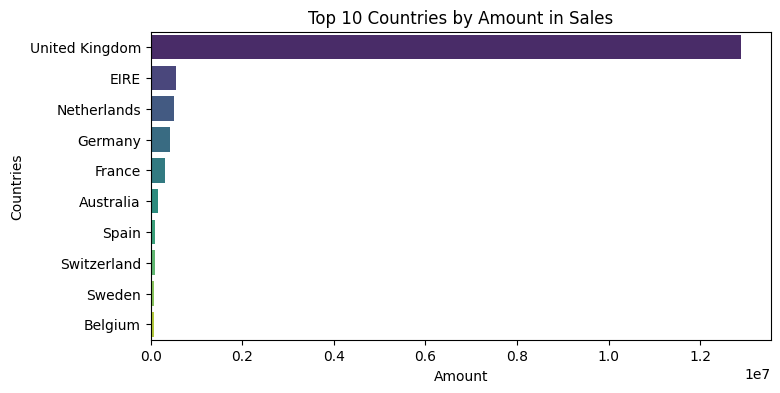

In [35]:
# Plot the bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x='Amount', y='Country', data=top_10_country_sales, palette='viridis')
plt.title(f'Top 10 Countries by Amount in Sales')
plt.xlabel('Amount')
plt.ylabel('Countries')
plt.show()

The same pattern is followed here as well

#### 4. Top 10 selling products based on the month

In [36]:
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour

In [37]:
sales_by_month = df.groupby('Month')['Quantity'].sum().reset_index()

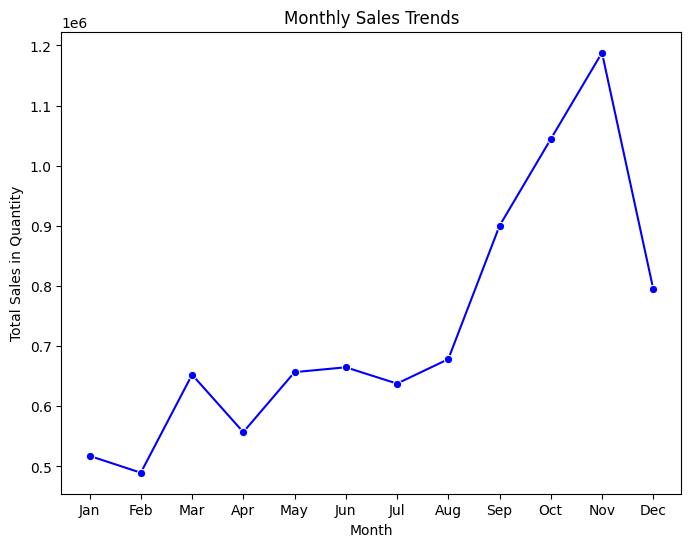

In [38]:
# Plot the monthly sales trends
plt.figure(figsize=(8, 6))
sns.lineplot(x='Month', y='Quantity', data=sales_by_month, marker='o', color='blue')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales in Quantity')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

We can see that there is huge rise in sale of products around second half of the year, especially during October and November, which is also holiday season. Let's further analyze which products are sold more in each month as this would help in planning the inventory

#### 5. Top products on monthly-basis as this would help us maintain the inventory

In [39]:
# Group by month and product description, calculate total sales, and rank products
monthly_top_products = (
    df.groupby(['Month', 'Description'])
    .agg({'Quantity': 'sum'})
    .reset_index())

In [40]:
# Rank products within each month based on total sales
monthly_top_products['Rank'] = monthly_top_products.groupby('Month')['Quantity'].rank(ascending=False, method='dense')

In [41]:
# Filter to get the top N products in each month (adjust N as needed)
top_n = 3
monthly_top_n_products = monthly_top_products[monthly_top_products['Rank'] <= top_n]

# Display the top products in each month
print(monthly_top_n_products)

       Month                          Description  Quantity  Rank
109        1          60 TEATIME FAIRY CAKE CASES      3523   3.0
111        1       72 SWEETHEART FAIRY CAKE CASES      4424   2.0
3132       1   WHITE HANGING HEART T-LIGHT HOLDER      6545   1.0
3373       2          60 TEATIME FAIRY CAKE CASES      4302   2.0
5174       2     PACK OF 72 RETRO SPOT CAKE CASES      3734   3.0
6417       2   WHITE HANGING HEART T-LIGHT HOLDER      4641   1.0
6655       3          60 TEATIME FAIRY CAKE CASES      4790   3.0
6739       3        ASSORTED COLOUR BIRD ORNAMENT      5571   2.0
9854       3   WHITE HANGING HEART T-LIGHT HOLDER      5934   1.0
10164      4        ASSORTED COLOUR BIRD ORNAMENT      5073   2.0
10690      4  COLOUR GLASS T-LIGHT HOLDER HANGING      3748   3.0
13084      4   WHITE HANGING HEART T-LIGHT HOLDER      5393   1.0
13944      5  COLOUR GLASS T-LIGHT HOLDER HANGING      5370   2.0
16370      5   WHITE HANGING HEART T-LIGHT HOLDER      7143   1.0
16444     

In [42]:
monthly_top_n_products['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     11
ASSORTED COLOUR BIRD ORNAMENT           6
JUMBO BAG RED RETROSPOT                 6
WORLD WAR 2 GLIDERS ASSTD DESIGNS       5
60 TEATIME FAIRY CAKE CASES             3
COLOUR GLASS T-LIGHT HOLDER HANGING     2
72 SWEETHEART FAIRY CAKE CASES          1
PACK OF 72 RETRO SPOT CAKE CASES        1
RABBIT NIGHT LIGHT                      1
Name: Description, dtype: int64

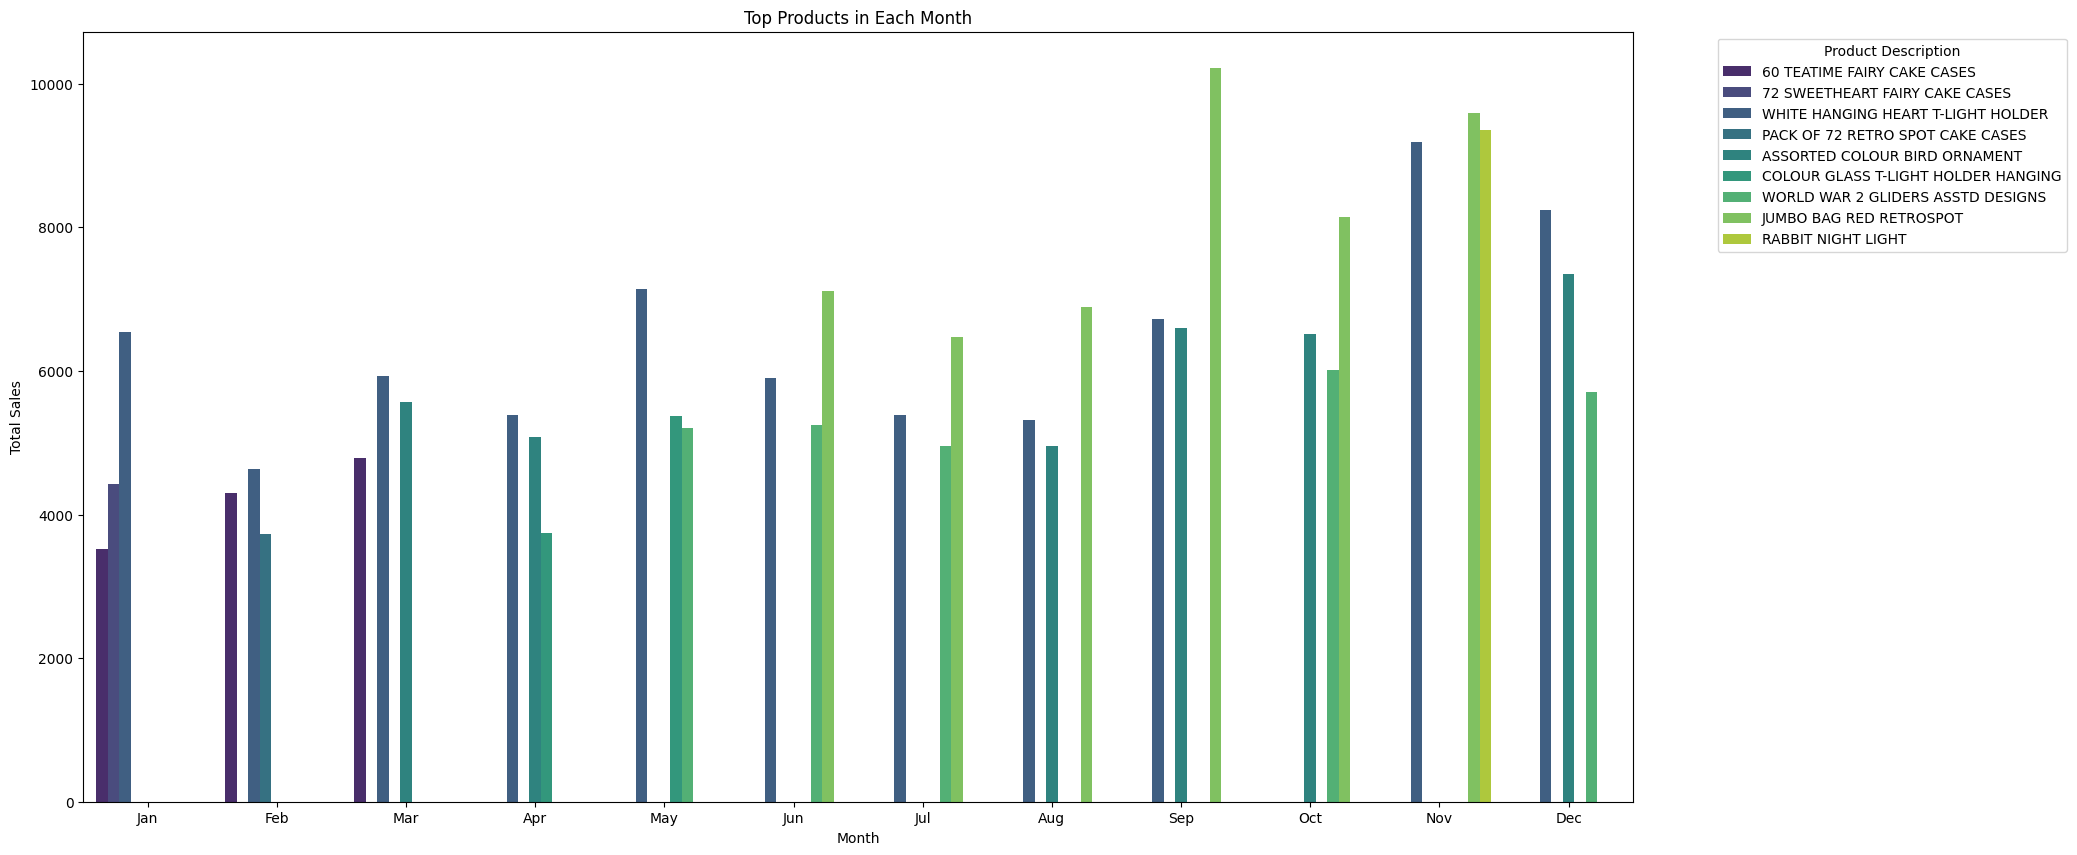

In [43]:
plt.figure(figsize=(20,10))

# Create a grouped bar plot
sns.barplot(x='Month', y='Quantity', hue='Description', data=monthly_top_n_products, palette='viridis')

# Add labels and title
plt.title('Top Products in Each Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Product Description', bbox_to_anchor=(1.05, 1), loc='best')
plt.show()

Insights - <br>
* 60 TEATIME FAIRY CAKE CASES - is being sold more mainly in the first 3 months of the year (Spring) <br>
* WHITE HANGING HEART T-LIGHT HOLDER - is one of their best selling products, as it is bought in huge volumes all year around <br>
* ASSORTED COLOUR BIRD ORNAMENT - is sold mainly in the second half of the year
* JUMBO BAG RED RETROSPOT - is sold abundantly in the months from June to November, peaking in the month of September

#### 6. Top products sold based on the Country the consumers buy from

In [44]:
# Group by country and product description, calculate total sales, and rank products
countrywise_top_products = (
    df.groupby(['Country', 'Description'])
    .agg({'Quantity': 'sum'})
    .reset_index())

In [45]:
countrywise_top_products

,Country,Description,Quantity
0,Australia,DOLLY GIRL BEAKER,200
1,Australia,I LOVE LONDON MINI BACKPACK,4
2,Australia,10 COLOUR SPACEBOY PEN,48
3,Australia,12 PENCILS SMALL TUBE RED SPOTTY,24
4,Australia,12 PENCILS TALL TUBE POSY,252
...,...,...,...
29210,West Indies,VINTAGE BEAD PINK SCARF,3
29211,West Indies,WHITE AND BLUE CERAMIC OIL BURNER,6
29212,West Indies,WOODLAND PARTY BAG + STICKER SET,1
29213,West Indies,WOVEN BERRIES CUSHION COVER,2


In [46]:
# Rank products within each country based on total sales
countrywise_top_products['Rank'] = countrywise_top_products.groupby('Country')['Quantity'].rank(ascending=False, method='dense')

In [47]:
# Filter to get the top N products in each country (adjust N as needed)
top_n = 1
countrywise_top_products = countrywise_top_products[countrywise_top_products['Rank'] <= top_n]

# Display the top products in each month
countrywise_top_products

,Country,Description,Quantity,Rank
176,Australia,DOLLY GIRL LUNCH BOX,1316,1.0
1293,Austria,SET 12 KIDS COLOUR CHALK STICKS,288,1.0
1428,Bahrain,ICE CREAM SUNDAE LIP GLOSS,96,1.0
1726,Belgium,DOLLY GIRL LUNCH BOX,572,1.0
2554,Brazil,DOLLY GIRL LUNCH BOX,25,1.0
2557,Brazil,DRAGONS BLOOD INCENSE,25,1.0
2832,Canada,WORLD WAR 2 GLIDERS ASSTD DESIGNS,288,1.0
2868,Channel Islands,AFGHAN SLIPPER SOCK PAIR,600,1.0
3986,Cyprus,HEART DECORATION PAINTED ZINC,384,1.0
4510,Czech Republic,WOODEN STAR CHRISTMAS SCANDINAVIAN,72,1.0


#### 7. Time-Series Analysis - Visualize monthly, daily and hourly sales trend

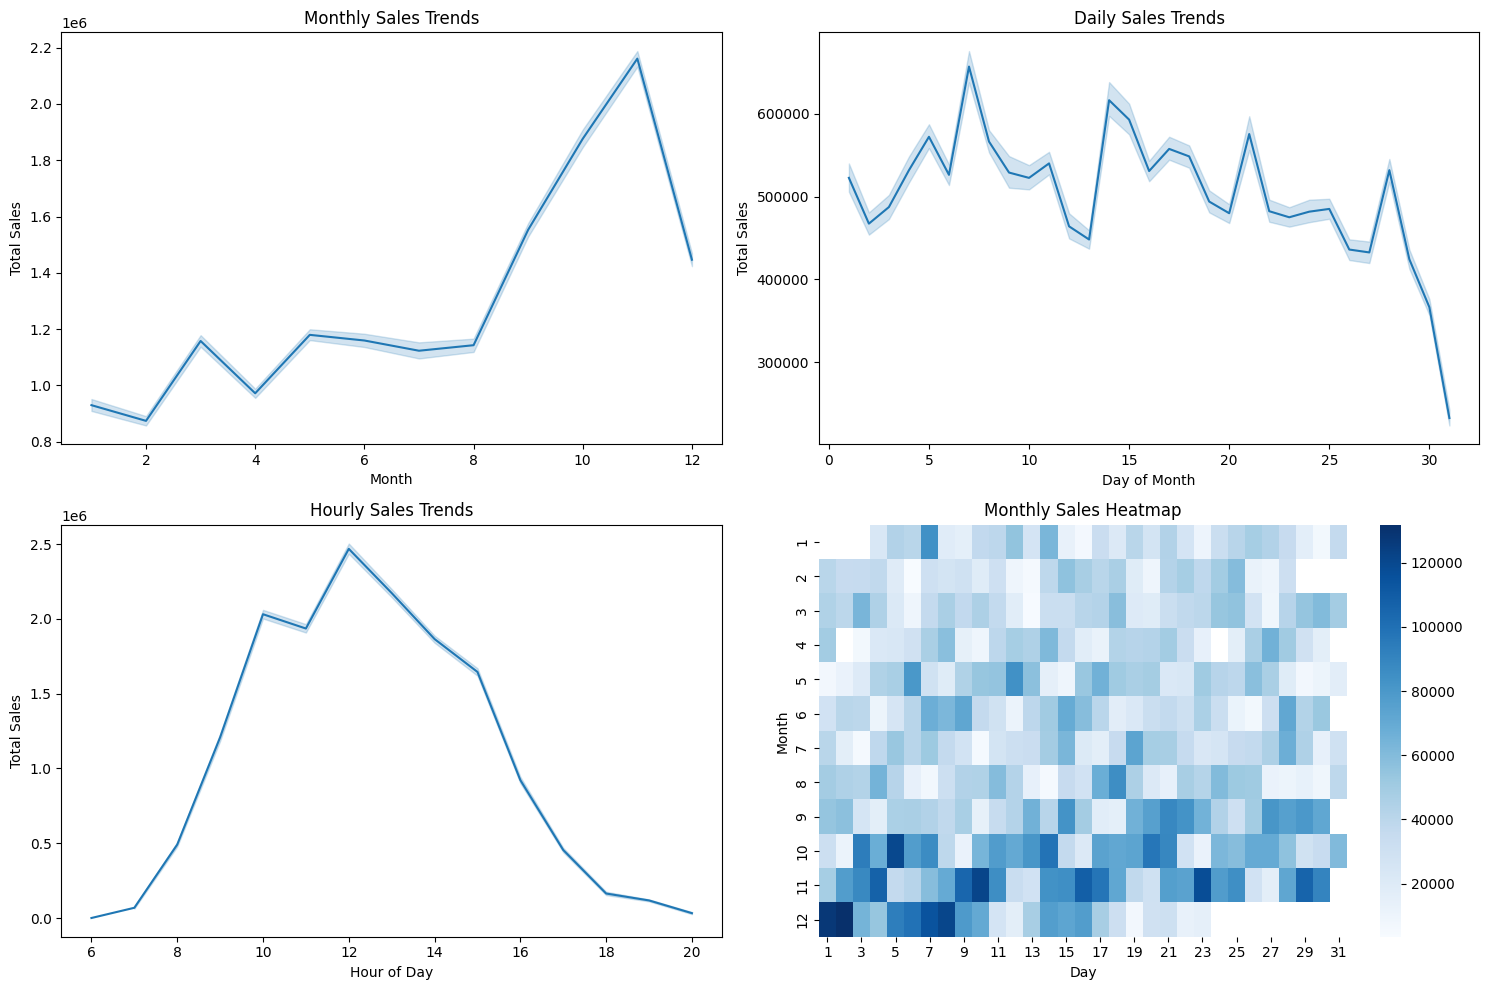

In [48]:
# Set up subplots for time-based analysis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Monthly sales trends
sns.lineplot(x='Month', y='Amount', data=df, estimator='sum', ax=axes[0, 0])
axes[0, 0].set_title('Monthly Sales Trends')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Total Sales')

# Daily sales trends
sns.lineplot(x='Day', y='Amount', data=df, estimator='sum', ax=axes[0, 1])
axes[0, 1].set_title('Daily Sales Trends')
axes[0, 1].set_xlabel('Day of Month')
axes[0, 1].set_ylabel('Total Sales')

# Hourly sales trends
sns.lineplot(x='Hour', y='Amount', data=df, estimator='sum', ax=axes[1, 0])
axes[1, 0].set_title('Hourly Sales Trends')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Total Sales')

# Monthly sales heatmap
monthly_sales_heatmap = df.groupby(['Month', 'Day'])['Amount'].sum().unstack()
sns.heatmap(monthly_sales_heatmap, cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Monthly Sales Heatmap')

plt.tight_layout()
plt.show()

* We can observe that there is a increased sale of goods in the last 5 months (more of the later half of the year)<br>
* The daily sales trend kind of stays constant, but declines towards the end of a month
* The hourly sale sees a spike in the middle of the day, and decreases in the very early and late hours
* The heatmap shows that the sale of goods is more during the last 3 months in contrast to the initial months of the year

#### 8. Correlation Analysis

In [49]:
# Calculate the Pearson correlation coefficient
correlation_coefficient, _ = pearsonr(df['Quantity'], df['Price'])

print(f"Pearson Correlation Coefficient: {correlation_coefficient}")
# Interpretation
if correlation_coefficient > 0:
    print("There is a positive correlation between Quantity and Price.")
elif correlation_coefficient < 0:
    print("There is a negative correlation between Quantity and Price.")
else:
    print("There is no correlation between Quantity and Price.")

Pearson Correlation Coefficient: -0.19047973245926025
There is a negative correlation between Quantity and Price.


This makes sense as well, because as the price of a product increases consumers tend to buy lower quantities of the product.

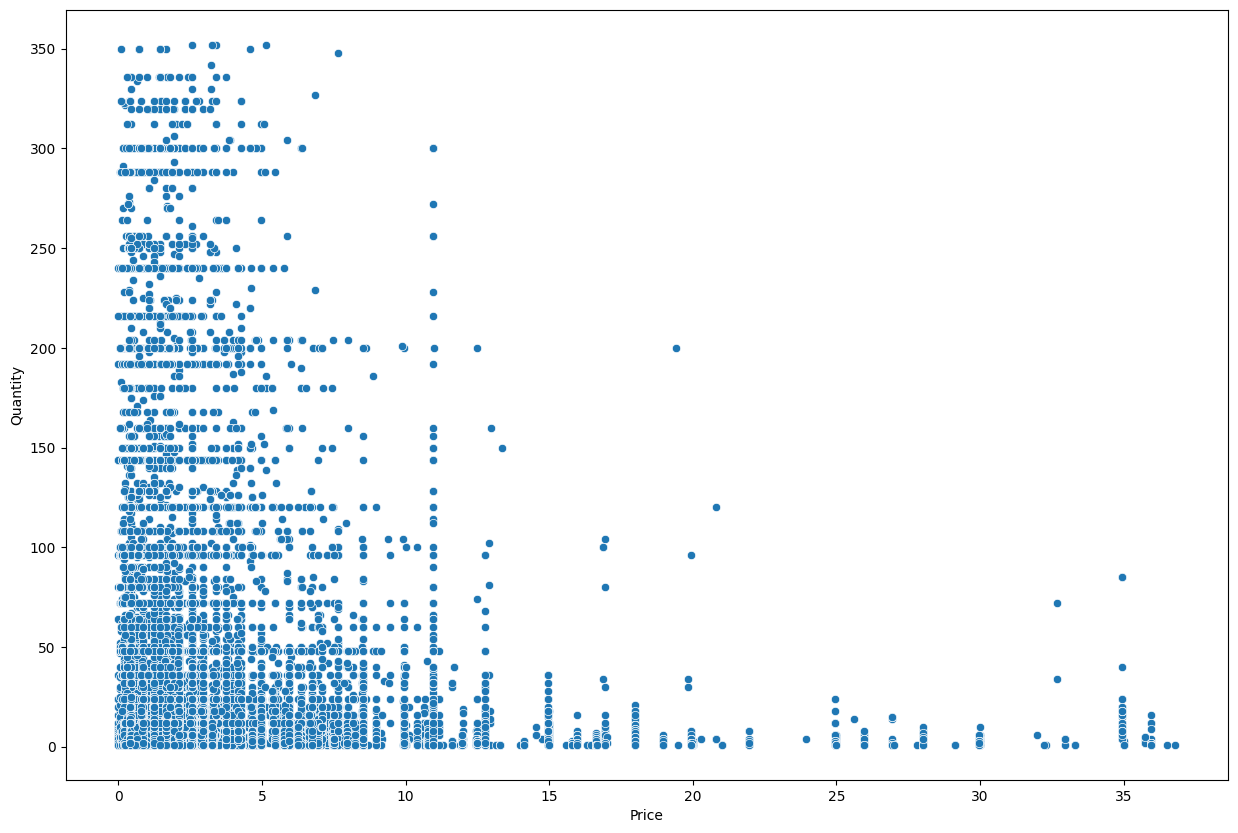

In [51]:
plt.figure(figsize = (15,10))
sns.scatterplot(data = df, x = df['Price'], y = df['Quantity'])
plt.show()

In [52]:
print('Correlation matrix :')
df.corr()

Correlation matrix :


,Quantity,Price,Customer ID,Amount,Month,Day,Hour
Quantity,1.000000,-0.190480,-0.054536,0.640127,-0.019210,-0.005967,-0.078898
Price,-0.190480,1.000000,-0.026243,0.133775,-0.020899,-0.001568,-0.011526
Customer ID,-0.054536,-0.026243,1.000000,-0.037775,0.028848,0.000497,0.065437
Amount,0.640127,0.133775,-0.037775,1.000000,-0.014668,-0.006945,-0.065528
Month,-0.019210,-0.020899,0.028848,-0.014668,1.000000,-0.115357,0.048030
Day,-0.005967,-0.001568,0.000497,-0.006945,-0.115357,1.000000,0.003809
Hour,-0.078898,-0.011526,0.065437,-0.065528,0.048030,0.003809,1.000000


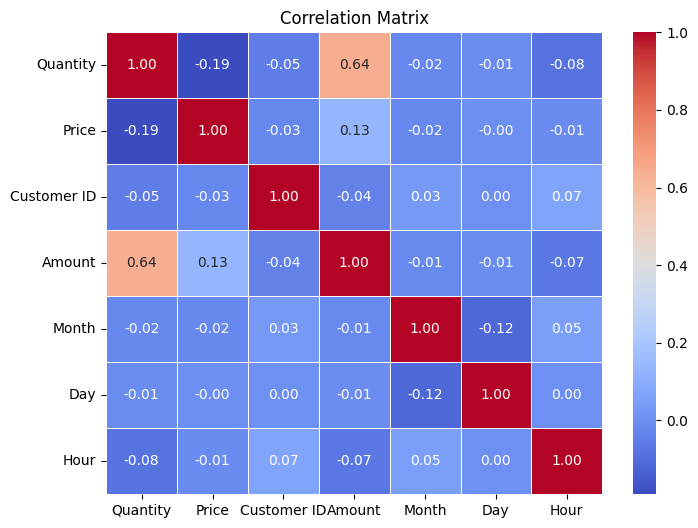

In [53]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

There doesn't seem to be any correlation majorly between any variables. There is significant correaltion between Quantity and Amount because Amount was derived using Quantity and Price.

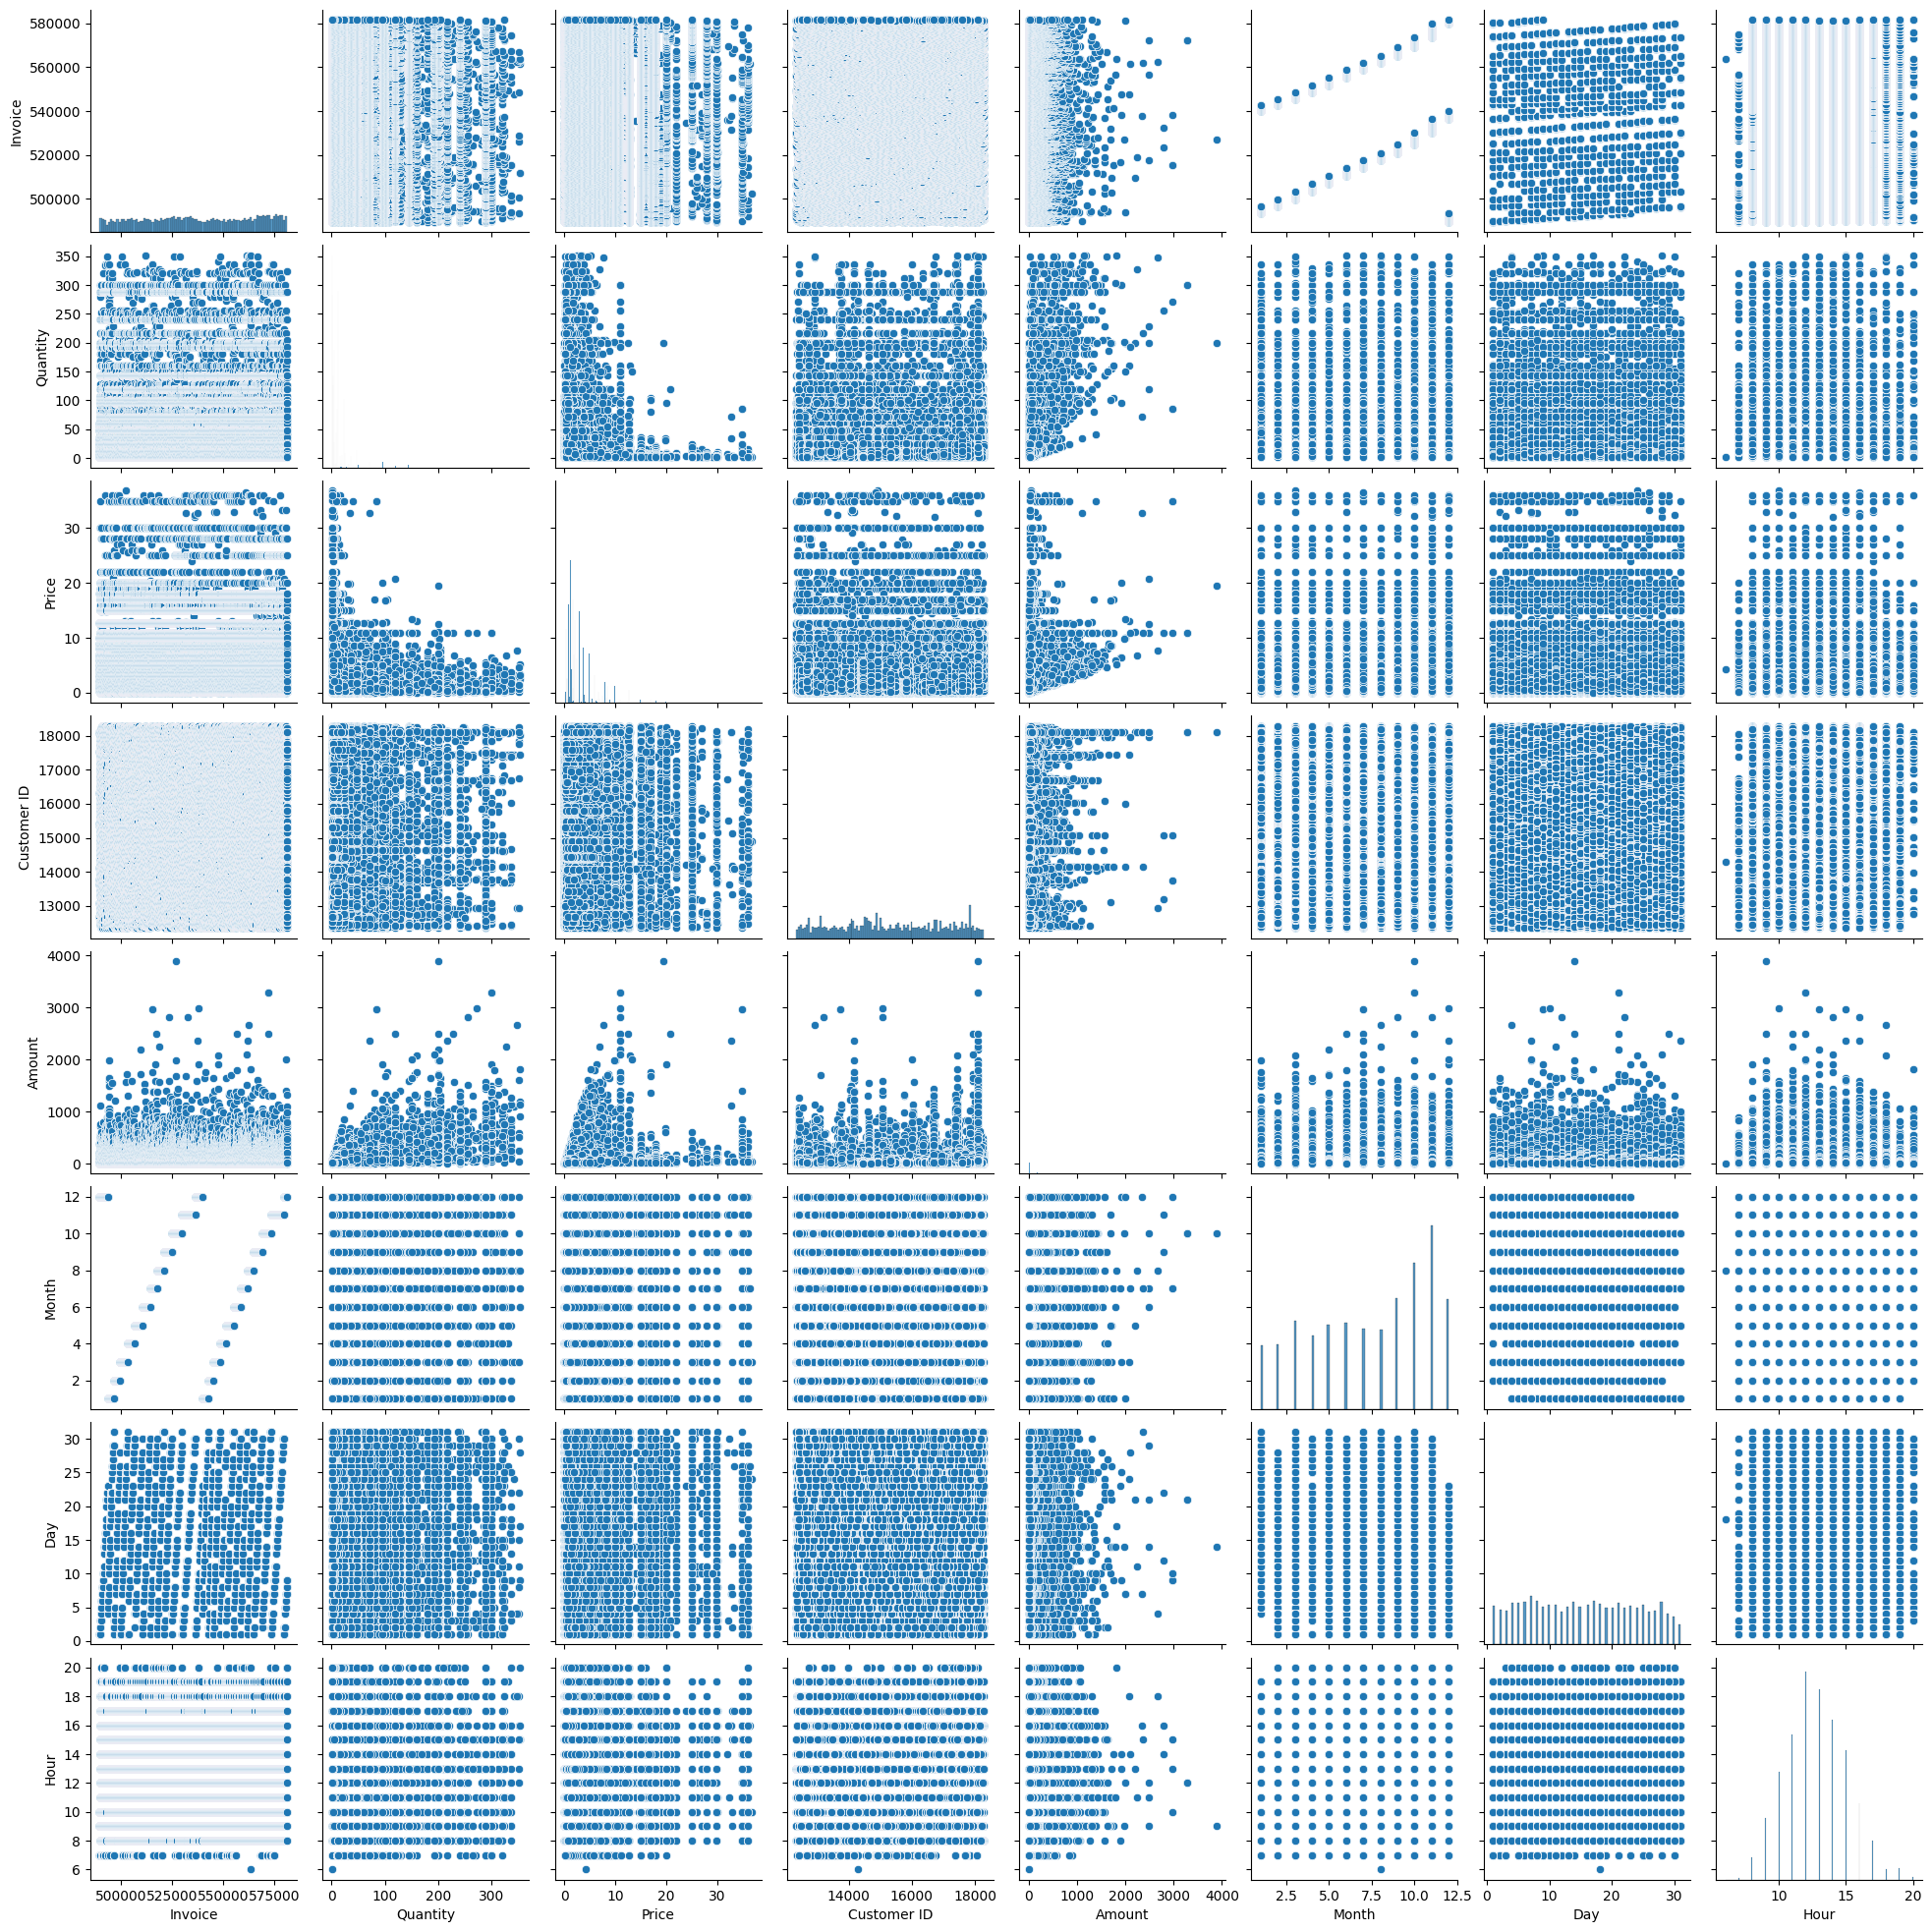

In [54]:
sns.pairplot(df)

#### 9. Start with Apriori Algorithm to get the association mining rules

The Apriori algorithm is commonly used for association rule mining. Before applying the Apriori algorithm, we need to format your data in a way that each row represents a transaction and each column represents an item

In [55]:
# Drop duplicate rows to ensure that the same product is not counted multiple times in a single transaction
df_unique = df[['Customer ID', 'Description']].drop_duplicates()
# Create a one-hot encoded matrix
basket = df_unique.pivot_table(index='Customer ID', columns='Description', aggfunc='size', fill_value=0)
basket

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18284.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18285.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Convert counts to binary values (0 or 1)
basket[basket > 0] = 1

In [57]:
basket.describe()

Description,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,Bank Charges,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
count,5833.000000,5833.000000,5833.000000,5833.000000,5833.000000,5833.000000,5833.000000,5833.000000,5833.000000,5833.000000,...,5833.000000,5833.000000,5833.000000,5833.000000,5833.000000,5833.000000,5833.000000,5833.000000,5833.000000,5833.000000
mean,0.008058,0.016458,0.006858,0.018001,0.001714,0.002057,0.001029,0.000343,0.001200,0.003772,...,0.000171,0.003086,0.011486,0.021430,0.000343,0.030516,0.007715,0.048003,0.002057,0.003086
std,0.089409,0.127240,0.082533,0.132966,0.041373,0.045314,0.032059,0.018515,0.034624,0.061303,...,0.013093,0.055470,0.106566,0.144825,0.018515,0.172017,0.087502,0.213790,0.045314,0.055470
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
# Convert to a sparse matrix
sparse_basket = csr_matrix(basket.values)

In [61]:
# Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(sparse_basket, min_support=0.02, use_colnames=True)

# Display the frequent itemsets
print("Frequent Itemsets:")
print(frequent_itemsets)

AttributeError: ignored

In [ ]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

# Display the association rules
print("\nAssociation Rules:")
print(rules)

In [ ]:
freq_items = fpgrowth(basket_sets,min_support = 0.01,use_colnames = True)
freq_items

In [ ]:
rules = association_rules(freq_items,metric = "confidence",min_threshold = 0.05)
rules.head(100)

In [ ]:
rules[(rules['lift'] >= 3) &
       (rules['confidence'] >= 0.5)]

In [ ]:
unique_values = unique_df['Description'].unique()
print("There are totally 5699 items in our store, what do you want to pick")
print(unique_values,sep = ",")
#print(len(unique_values))

In [ ]:
item="ROSES REGENCY TEACUP AND SAUCER "
filtered = rules[rules["antecedents"] == frozenset({item})]["consequents"]
filtered.size
if filtered.size == 0:
    print("There are no recommended items for this product, choose a different item")
else:
    print("Here are your recommended items for  "+item+"--")
    print(filtered)
    items = []
    for data in filtered:
        items.extend(data)

In [ ]:
item=input("What is the item you want to pick")
filtered = rules[rules["antecedents"] == frozenset({item})]["consequents"]
filtered.size
if filtered.size == 0:
    print("There are no recommended items for this product, choose a different item")
else:
    print("Here are your recommended items for  "+item+"--")
    print(filtered)
    items = []
    for data in filtered:
        items.extend(data)

### RFM analysis

Customer segmentation is the practice of grouping customers based on common characteristics. These customer segments are beneficial in marketing campaigns, in identifying potentially profitable customers, and in developing customer loyalty. A company might segment customers according to a wide range of factors, including: demographics (age, gender, location etc), behaviour (previous orders, responses to messaging), psychographics (values, interests, lifestyles) etc.

RFM (Recency-Frequency-Monetary) analysis is a simple technique for behaviour based customer segmentation. It groups customers based on their transaction history – how recently, how often and how much did they buy. It is a handy method to find the best customers, understand their behavior and then run targeted marketing campaigns to increase sales, satisfaction and customer lifetime value.

In [ ]:
# Calculate RFM metrics

current_date = max(df['InvoiceDate'])  # Current date
rfm_df = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency
    'Price': 'sum'  # Monetary value
})

# Rename columns for clarity

rfm_df.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Price': 'Monetary'
}, inplace=True)

# Print the first few rows of the RFM DataFrame
rfm_df = rfm_df.sort_values(by = 'Monetary',ascending = False)
print(rfm_df.head())

We are sorting them in descening order of Monetary value as the Monetary aspect is a crucial component of RFM analysis as it helps segment customers based on their purchasing behavior and contribution to revenue. Customers who spend more tend to be more valuable to a business, and identifying these high-value customers can assist in targeted marketing strategies, loyalty programs, and personalized offerings to maximize revenue and customer retention.

Now we will be converting these values to the range from 1 to 5 across all the metrics for easier segmentation and for having a consistent range across all the metrics

In [ ]:
r_labels, f_labels, m_labels = range(1, 6), range(1,6), range(1,6)
# Define custom bins (adjust according to your data distribution)
custom_bins = [0, 5, 10, 20, 30, 1000]

# Use pd.cut() with custom bins
rfm_df['r_score'] = pd.qcut(rfm_df['Recency'], q=5, labels=r_labels).astype(int)
rfm_df['f_score'] = pd.cut(rfm_df['Frequency'], bins=custom_bins, labels=f_labels).astype(int)
rfm_df['m_score'] = pd.qcut(rfm_df['Monetary'], q=5, labels=m_labels).astype(int)

rfm_df['rfm_sum'] = rfm_df['r_score'] + rfm_df['m_score'] + rfm_df['f_score']
rfm_df = rfm_df.sort_values(by = "rfm_sum",ascending = False)
rfm_df

Customers with the highest RFM score is considered the "best" customer. They have made recent purchases (high R), engage frequently (high F), and contribute significantly in terms of monetary value (high M). These customers are often considered the most valuable and important for the business.

We will be assigning labels to the customers based on their transaction history

In [ ]:
def assign_label(df, r_rule, fm_rule, label, colname='rfm_label'):
    df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
            & (df['f_score'].between(fm_rule[0], fm_rule[1])), colname] = label
    return df

In [ ]:
rfm_df['rfm_label'] = ''

rfm_df = assign_label(rfm_df, (5,5), (4,5), 'champions')
rfm_df = assign_label(rfm_df, (3,4), (4,5), 'loyal customers')
rfm_df = assign_label(rfm_df, (4,5), (2,3), 'potential loyalist')
rfm_df = assign_label(rfm_df, (5,5), (1,1), 'new customers')
rfm_df = assign_label(rfm_df, (4,4), (1,1), 'promising')
rfm_df = assign_label(rfm_df, (3,3), (3,3), 'needing attention')
rfm_df = assign_label(rfm_df, (3,3), (1,2), 'about to sleep')
rfm_df = assign_label(rfm_df, (1,2), (3,4), 'at risk')
rfm_df = assign_label(rfm_df, (1,2), (5,5), 'cant loose them')
rfm_df = assign_label(rfm_df, (1,2), (1,2), 'hibernating')
rfm_df

In [ ]:
segments = ['loyal customers', 'hibernating', 'potential loyalist']

for col in ['Recency','Frequency','Monetary']:
    fig, ax = plt.subplots(figsize=(12,3))
    for segment in segments:
        sns.distplot(rfm_df[rfm_df['rfm_label']==segment][col], label=segment)
    ax.set_title('Distribution of %s' % col)
    plt.legend()
    plt.show()

## K means clustering for customer segmentation

In [ ]:
cluster_df = pd.DataFrame()
for i in ['Recency','Frequency','Monetary']:
    cluster_df[i] = rfm_df[i]
cluster_df

In [ ]:
scaler = StandardScaler()
rfm_cluster_scaled = scaler.fit_transform(cluster_df)
rfm_cluster_scaled

In [ ]:
kmeans = KMeans(n_clusters = 4,max_iter = 50)
kmeans.fit(rfm_cluster_scaled)

In [ ]:
plt.scatter(rfm_df['Recency'], rfm_df['Frequency'], c=rfm_df['Monetary'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Customer Segmentation')
plt.show()